## Table of content

- Before you start
- Install `ultralytics`, `wandb`, `roboflow`, and `supervision`
- Imports
- Download dataset from Roboflow
- Log dataset to W&B
- Examine training results

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Dec 11 16:42:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install `ultralytics`, `wandb`, `roboflow`, and `supervision`

In [ ]:
!pip install -q ultralytics==8.0.186 wandb roboflow supervision

## Imports

In [44]:
import cv2
import wandb
import roboflow
import supervision as sv

from wandb.integration.ultralytics import add_wandb_callback
from ultralytics import YOLO
from tqdm.notebook import tqdm

from IPython.display import Image, display

## Download dataset from Roboflow

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

/content/datasets


In [7]:
roboflow.login()

rf = roboflow.Roboflow()

project = rf.workspace("roboflow-jvuqo").project("football-players-detection-3zvbc")
dataset = project.version(4).download("yolov8")

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.186, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to football-players-detection-4 in yolov8:: 100%|██████████| 522/522 [00:00<00:00, 2363.51it/s]


In [8]:
dataset.location

'/content/datasets/football-players-detection-4'

## Log dataset to W&B

In [ ]:
wandb.init(project="ultralytics")

In [31]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/train/images",
    annotations_directory_path=f"{dataset.location}/train/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

In [32]:
ds.classes

['ball', 'goalkeeper', 'player', 'referee']

In [40]:
table = wandb.Table(columns=["ID", "Image"])

for image_name, image, detections in tqdm(ds, total=len(ds)):
    box_img = wandb.Image(
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB),
        boxes={
            "prediction": {
                "box_data": [
                    {
                        "position": {
                            "minX": int(xyxy[0]),
                            "minY": int(xyxy[1]),
                            "maxX": int(xyxy[2]),
                            "maxY": int(xyxy[3]),
                        },
                        "class_id": int(class_id),
                        "box_caption": ds.classes[class_id],
                        "domain": "pixel",
                    }
                    for xyxy, _, confidence, class_id, _
                    in detections
                ],
                "class_labels": {
                    i: class_label
                    for i, class_label
                    in enumerate(ds.classes)
                },
            }
        },
    )
    table.add_data(image_name, box_img)

  0%|          | 0/204 [00:00<?, ?it/s]

In [43]:
wandb.log({"Table": table})

⚠️ **NOTE:** Make sure to edit `data.yaml`.

## Custom training

In [9]:
MODEL_CHECKPOINT = "yolov8n.pt"
EPOCHS = 5
IMAGE_SIZE = 640

**NOTE:** Learn more about W&B Ultralytics [integration](https://docs.wandb.ai/guides/integrations/ultralytics).

In [ ]:
model = YOLO(MODEL_CHECKPOINT)

add_wandb_callback(model, enable_model_checkpointing=True)

model.train(project="ultralytics", data=f"{dataset.location}/data.yaml", epochs=EPOCHS, imgsz=IMAGE_SIZE)
model.val()

In [ ]:
wandb.finish()

## Examine training results

⚠️ **NOTE:** If you see the following error: `NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968`, run cell below.

In [14]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

In [16]:
!ls {HOME}/datasets/ultralytics/train/

args.yaml					    P_curve.png       train_batch2.jpg
confusion_matrix_normalized.png			    PR_curve.png      val_batch0_labels.jpg
confusion_matrix.png				    R_curve.png       val_batch0_pred.jpg
events.out.tfevents.1702313112.c2b4a6fdb633.1021.0  results.csv       val_batch1_labels.jpg
F1_curve.png					    results.png       val_batch1_pred.jpg
labels_correlogram.jpg				    train_batch0.jpg  weights
labels.jpg					    train_batch1.jpg


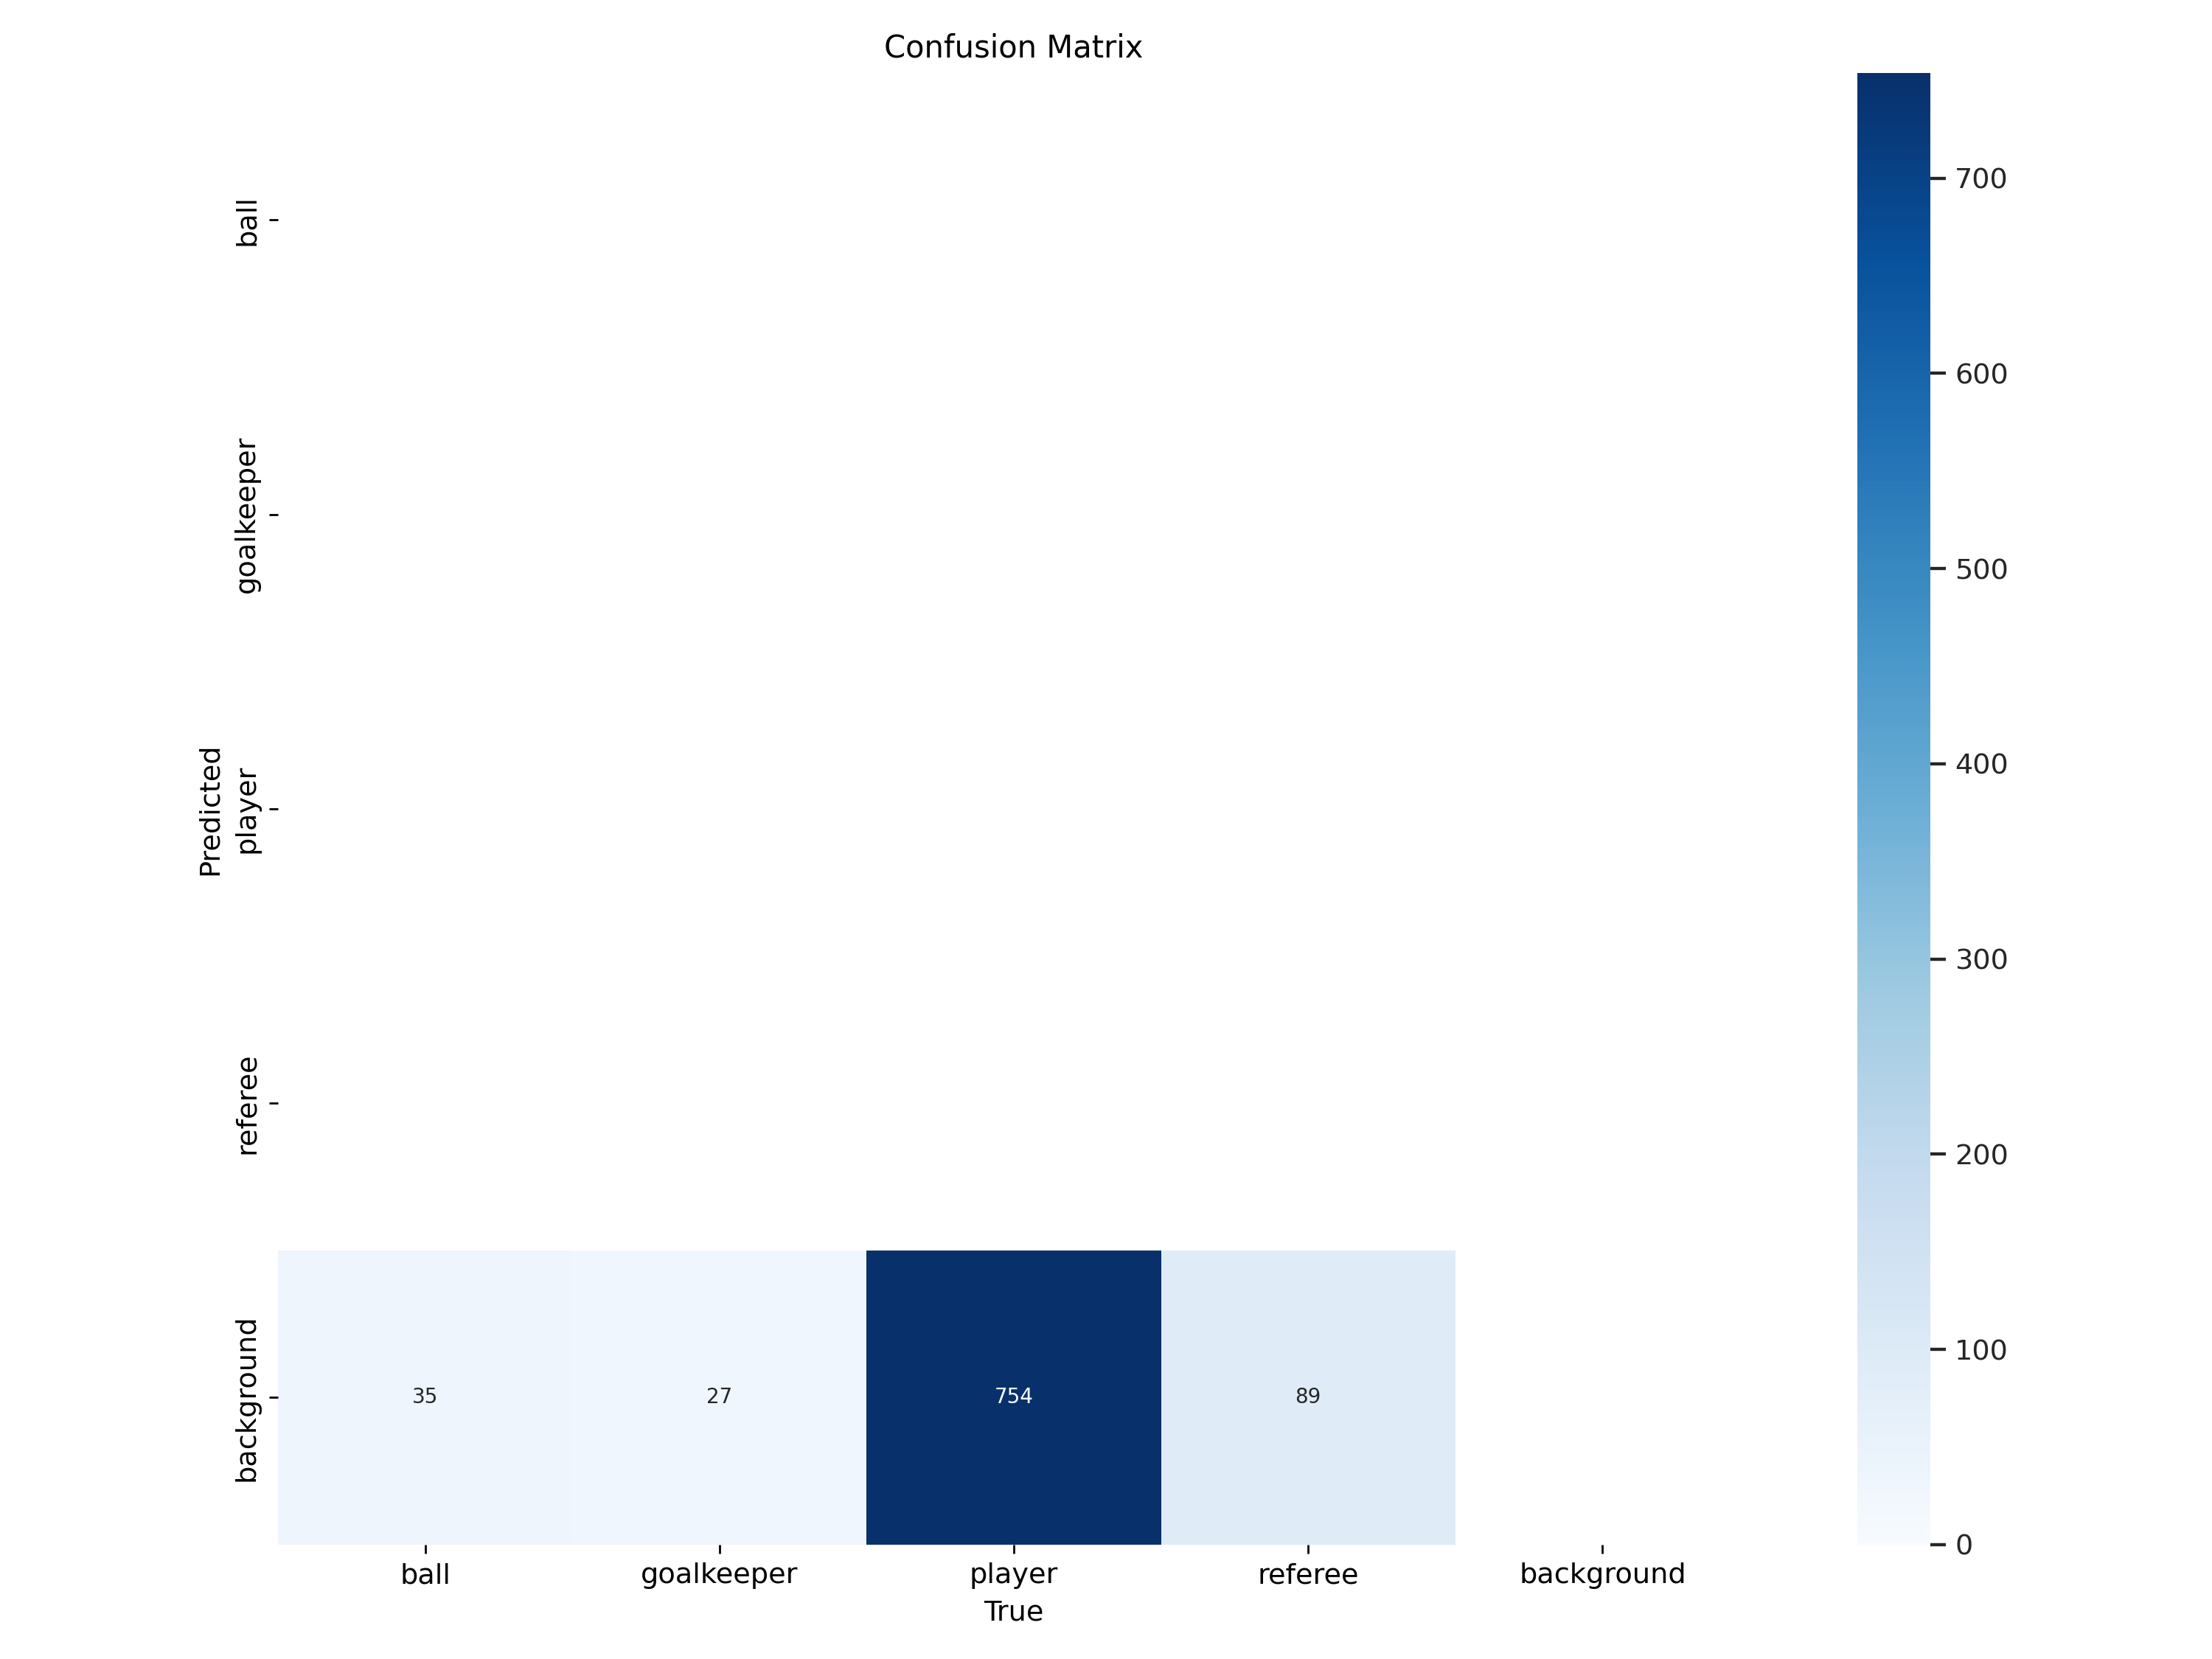

In [22]:
Image(filename=f'{HOME}/datasets/ultralytics/train/confusion_matrix.png', width=800)

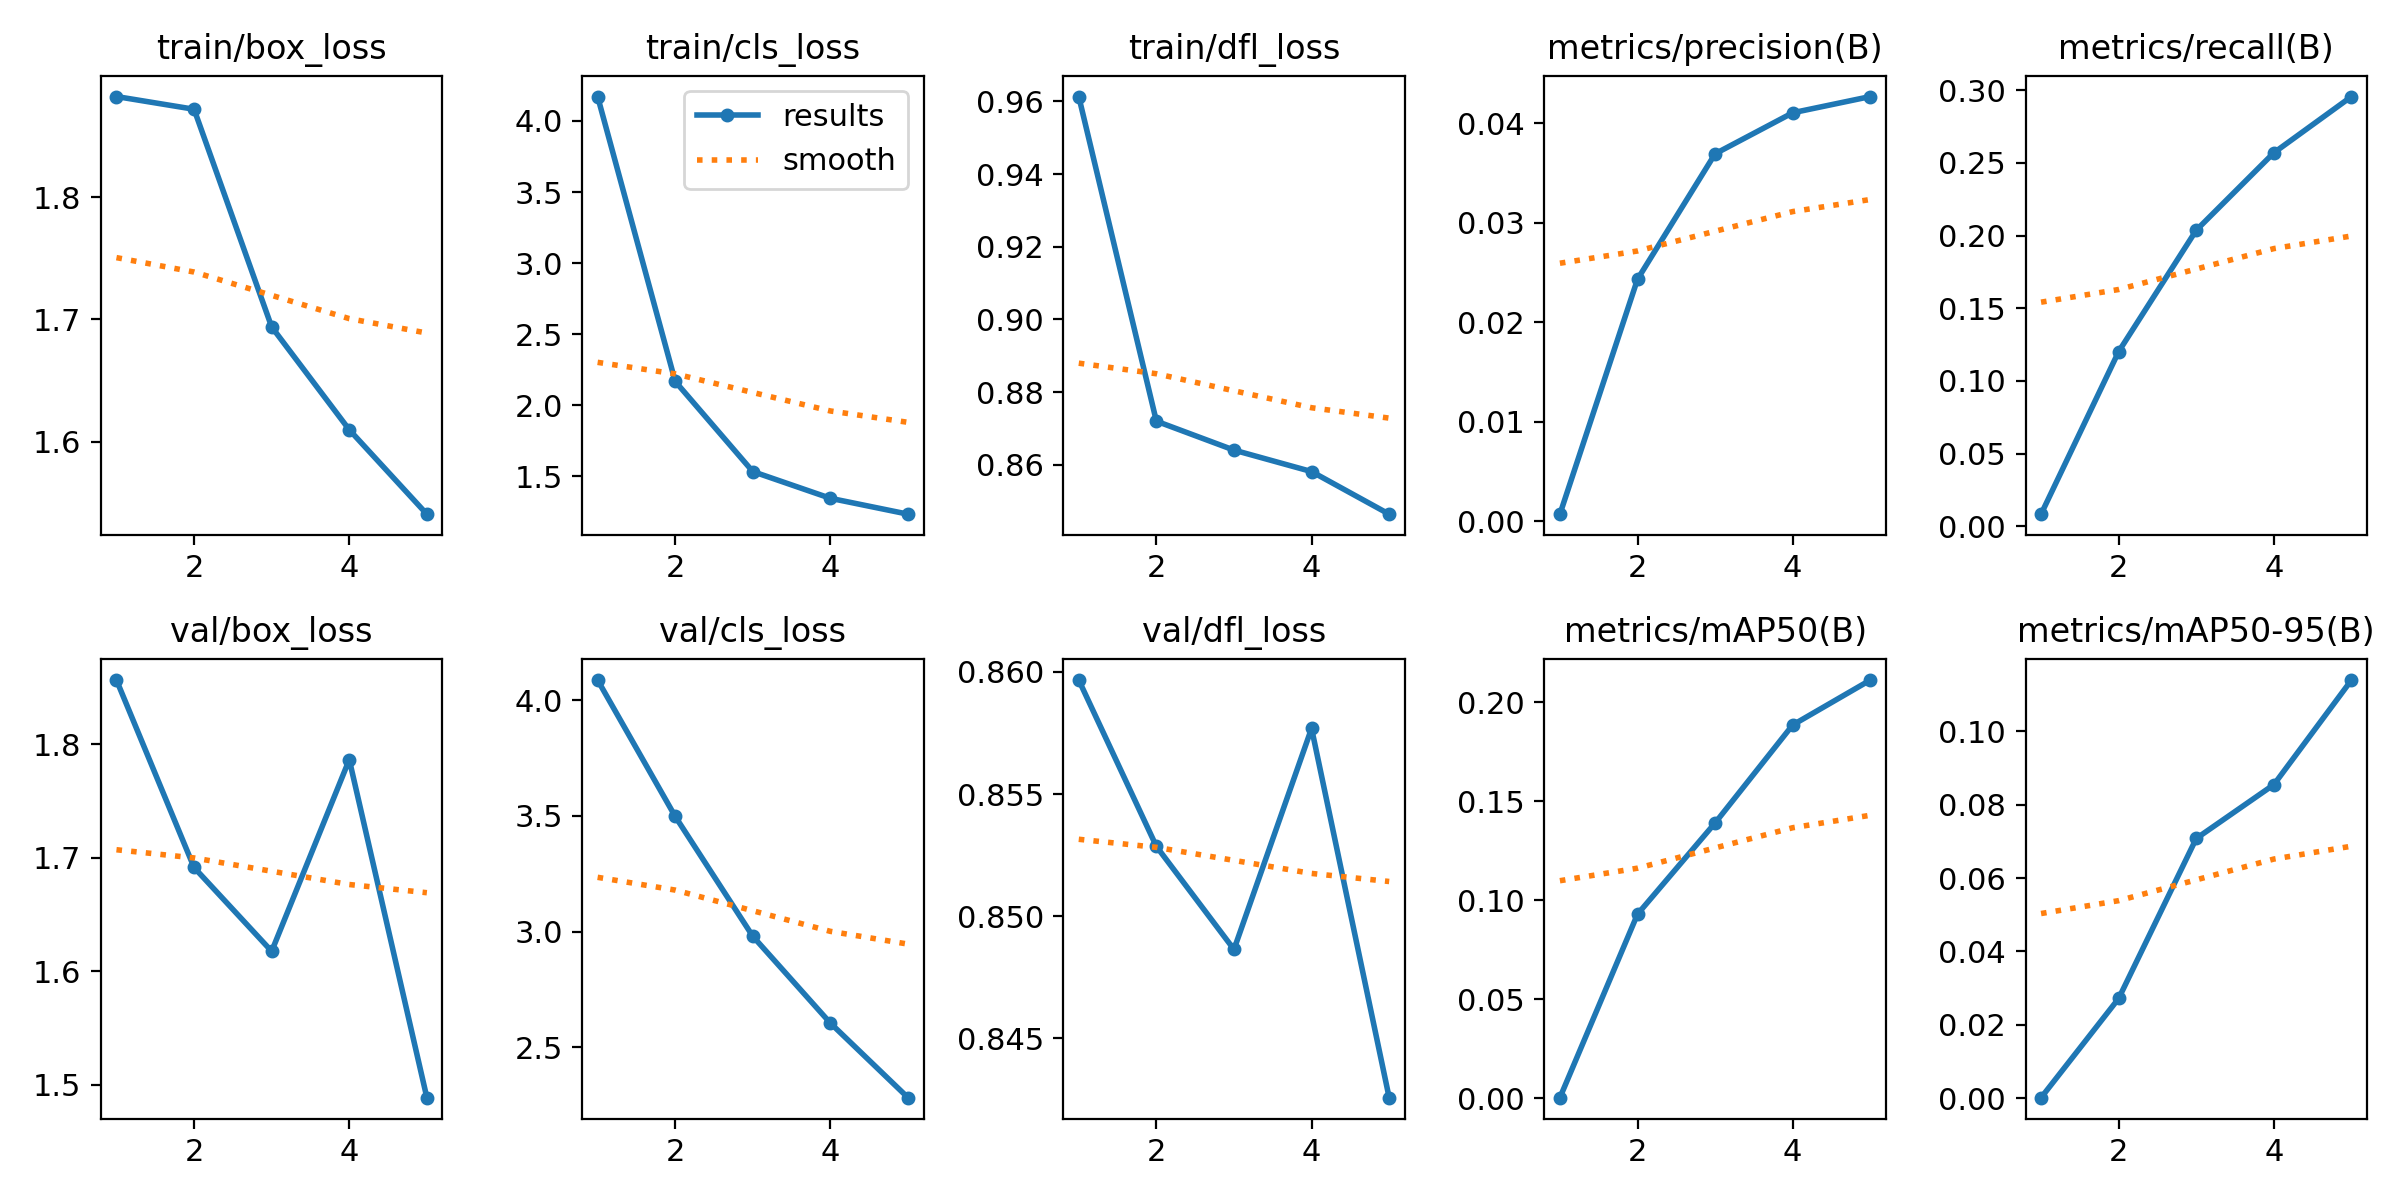

In [23]:
Image(filename=f'{HOME}/datasets/ultralytics/train/results.png', width=800)

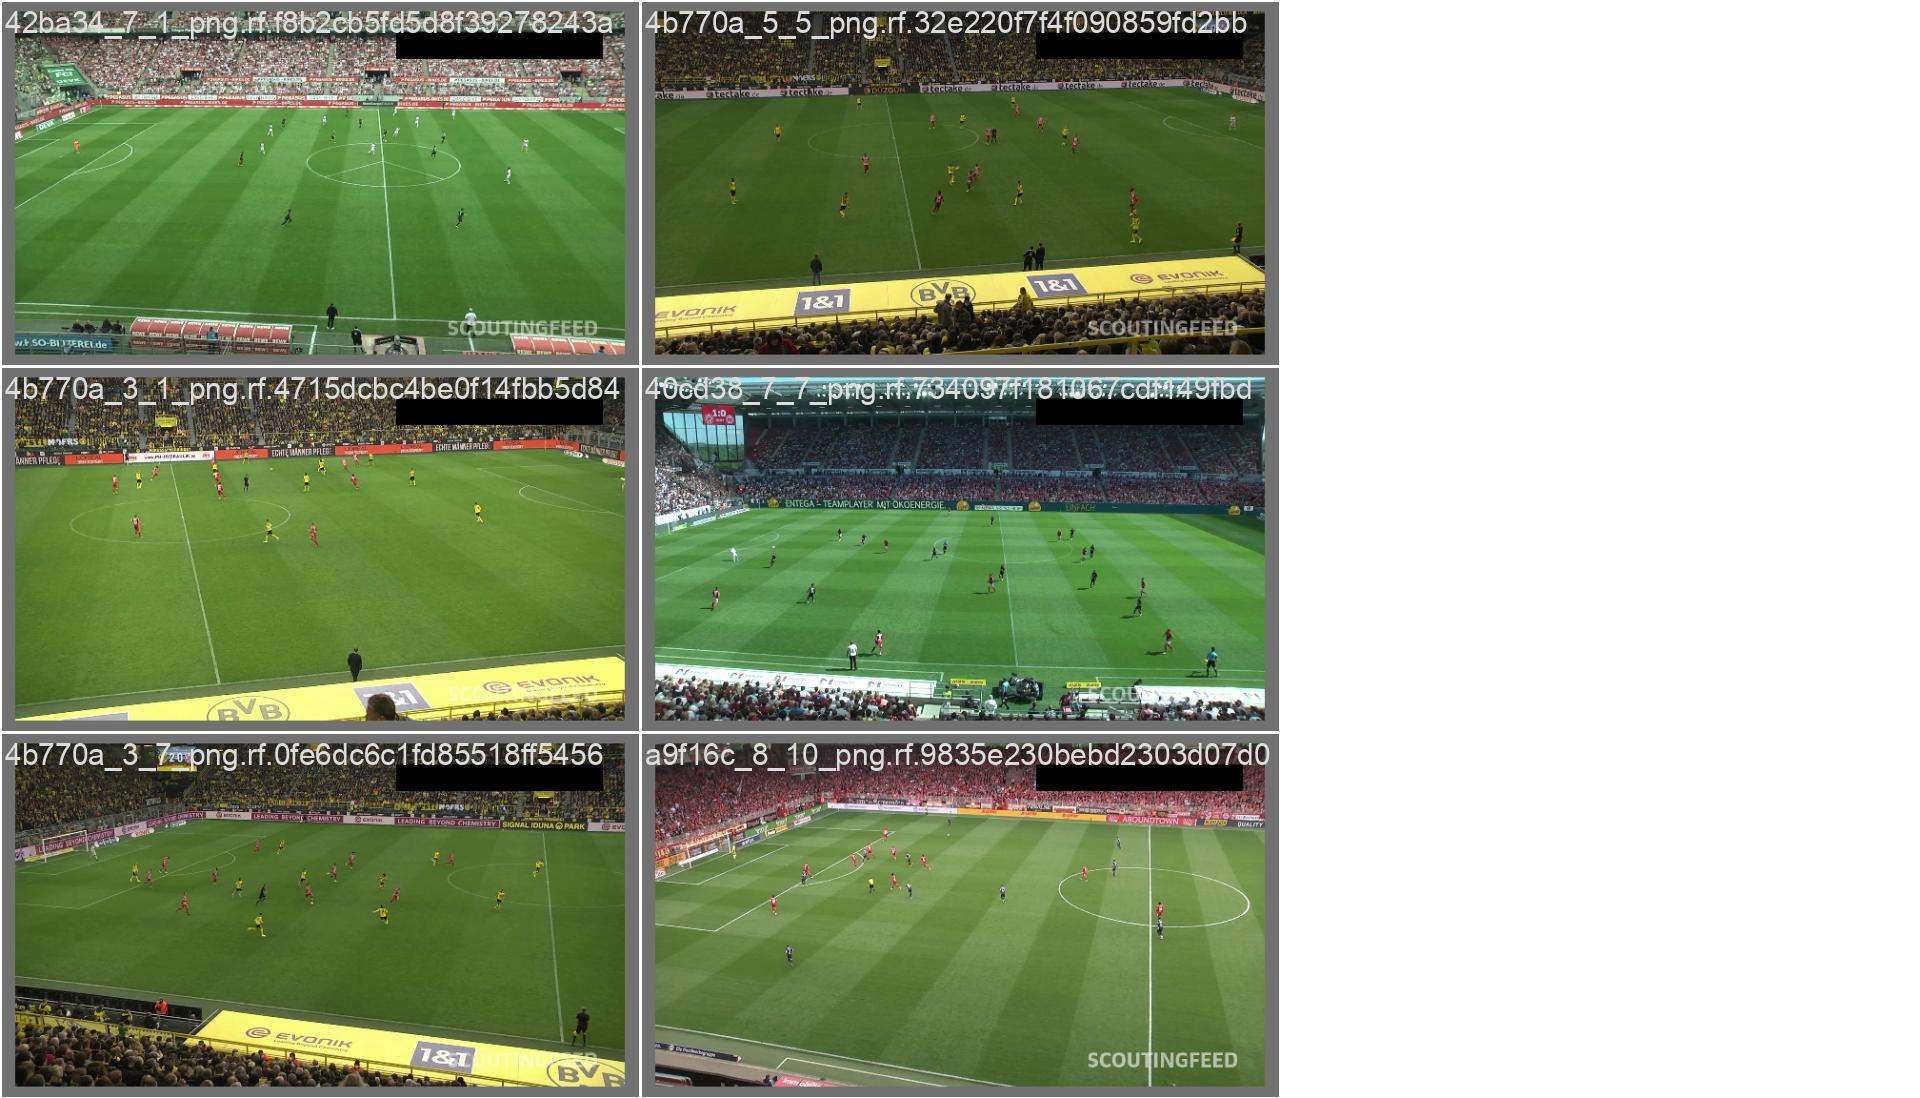

In [25]:
Image(filename=f'{HOME}/datasets/ultralytics/train/val_batch0_pred.jpg', width=800)

## Validate custom model

In [26]:
!yolo task=detect mode=val model={HOME}/datasets/ultralytics/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics YOLOv8.0.186 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006428 parameters, 0 gradients
val: Scanning /content/datasets/football-players-detection-4/valid/labels.cache... 38 images, 0 backgrounds, 0 corrupt: 100% 38/38 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 3/3 [00:03<00:00,  1.23s/it]
                   all         38        905     0.0429      0.296      0.212      0.115
                  ball         38         35          0          0          0          0
            goalkeeper         38         27    0.00175     0.0741    0.00109   0.000591
                player         38        754      0.165       0.94      0.837      0.455
               referee         38         89    0.00453      0.169    0.00793    0.00432
Speed: 6.3ms preprocess, 27.0ms inference, 0.0ms loss, 11.6ms postprocess per image
Results saved to runs/detect/val
💡 Learn mor

## Inference with custom model